In [1]:
!python ../setup.py build_ext --inplace

running build_ext
gcc -pthread -B /root/anaconda3/envs/py2/compiler_compat -Wl,--sysroot=/ -fno-strict-aliasing -g -O2 -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/root/anaconda3/envs/py2/include/python2.7 -c /tmp/tmp24IrPa.cpp -o tmp/tmp24IrPa.o -std=c++14
cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++
gcc -pthread -B /root/anaconda3/envs/py2/compiler_compat -Wl,--sysroot=/ -fno-strict-aliasing -g -O2 -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/root/anaconda3/envs/py2/include/python2.7 -c /tmp/tmpexmnz4.cpp -o tmp/tmpexmnz4.o -fvisibility=hidden
cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++
building 'coresets.sensitivity' extension
gcc -pthread -B /root/anaconda3/envs/py2/compiler_compat -Wl,--sysroot=/ -fno-strict-aliasing -g -O2 -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/root/anaconda3/envs/py2/include -I/root/anaconda3/envs/py2/include -I/r

In [2]:
!python --version

Python 2.7.17 :: Anaconda, Inc.


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
np.random.seed(42)
#from utils import datagen, plotting
#import coresets
#import algorithms
import csv
import math
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize, scale
from math import sqrt,log
import pandas as pd
import tensorflow as tf
import timeit 

from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier 
#import xgboost as xgb
from sklearn.metrics import accuracy_score,classification_report,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier

# Importing the required Keras modules containing model and layers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [3]:
##few func defintions
#normalize pdf area to 1:
def normaliz(array):
    normalized = []
    s=sum(array)
    for i in range(len(array)):
        n=array[i]/s
        normalized.append(n)
    return normalized
#Calculate mean
def mean(array):
    return sum(array)/float(len(array))
 
# Calculate the standard deviation of a list of numbers
def stdev(numbers):
    avg = mean(numbers)
    variance = sum([(x-avg)**2 for x in numbers]) / float(len(numbers)-1)
    return sqrt(variance)
#kl divergence
def kl(p, q):
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    c = 0
    for i in range(len(p)):
        if(p[i]!=0) and (q[i]!=0):
        #if(p[i]!=0):
            c=c+p[i]*log(p[i]/q[i])     
    return c
    #return np.sum(np.where(p != 0 , p * np.log(p / q), 0))
    
def dist(x,y):   
    return sqrt(np.sum((x-y)**2))

def cost(data,clusters):
    k=len(clusters)
    min_dist = []
    for i in range(len(data)):
        d = []
        for j in range(k):
            d.append(dist(data[i],clusters[j]))
        min_dist.append(np.min(d))
    cost = sum(min_dist)
    return cost
#kl divergence
def kl(p, q):
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    c = 0
    for i in range(len(p)):
        if(p[i]!=0) and (q[i]!=0):
        #if(p[i]!=0):
            c=c+p[i]*log(p[i]/q[i])     
    return c
    #return np.sum(np.where(p != 0 , p * np.log(p / q), 0))
    

In [4]:
#window kernel
def window_function(x_vec, unit_len=1):
    for row in x_vec:
        if np.abs(row) > (unit_len/2):
            return 0
    return 1

def kernel_func(h, x, x_i):
    assert (x.shape == x_i.shape), 'vectors x and x_i must have the same dimensions'
    return (x - x_i) / h

def window_func(x_vec, h):
   
    for row in x_vec:
        if np.abs(row) > 0.5:
            #print(row)
            return 0
    return 1
    #dist=sqrt(np.sum((x_vec)**2))
    #print("distance="+str(dist))
    #if dist > 0.5:
     #   return 0
    #else: 
     #   return 1

#main parzen window function
def parzen_estimate(x_samples, point_x, h, d):
    
    k_n = 0
    for row in x_samples:
        x_i = kernel_func(h=h, x=point_x, x_i=row[:,np.newaxis])
        #x_i = kernel_func(h=h, x=point_x, x_i=row)
        k_n += window_func(x_i, h=h)
        
    #print(k_n)
    temp1=float(k_n)/(h**d)
    temp2=temp1/len(x_samples)
    return temp2
    #return (float(k_n) / len(x_samples)) / (h**d)
    
def covar(data):
    mean_data=data.mean(axis=0)   
    cov=np.zeros((len(mean_data),len(mean_data)))
    for i in range(len(mean_data)):
        for j in range(len(mean_data)):
            for k in range(len(data)):
                cov[i][j]=cov[i][j]+((data[k][i]-mean_data[i])*(data[k][j]-mean_data[j]))
            cov[i][j]=cov[i][j]/(len(data)-1)
    return cov  

def show_img(data,idx):
    data *= 255
    im=np.reshape(data[idx],(28,28))
    plt.imshow(im,cmap='Greys')

In [5]:
#import MNIST train set
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_df=pd.read_csv('mnist_train.csv', sep=',')

#convert df to np
x_train_temp_np=x_train_df.to_numpy()

#dividing into labels and data 
x_train_data=x_train_temp_np[:, 1:785]
x_train_label=x_train_temp_np[:,[0]]


In [6]:
#import MNIST test set
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_test_df=pd.read_csv('mnist_test.csv', sep=',')

#convert df to np
x_test_temp_np=x_test_df.to_numpy()

#dividing into labels and data 
x_test_data=x_test_temp_np[:, 1:785]
x_test_label=x_test_temp_np[:,[0]]



In [7]:
#normalizing both train and test data with max RGB value
x_train_data_norm=x_train_data.astype('float')
x_test_data_norm=x_test_data.astype('float')
x_train_data_norm/=255
x_test_data_norm/=255
data_length=20000
b=int(sqrt(data_length))
print(b)

141


In [8]:
x_train_data_norm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

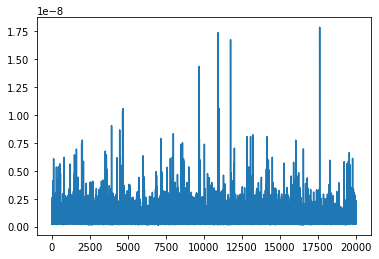

In [13]:
df=pd.read_csv('MNIST_KL20.csv')#load 20K
kl_load20=df.to_numpy()
plt.plot(kl_load20)
plt.show()




In [14]:
#convert training record to 2D for DL feeding

x_train_data_2D = []
print(len(x_train_data_norm[0:20000]))
for i in range(len(x_train_data_norm[0:20000])):
    #x_test_data_norm[i] *= 255
    sqr_test=np.reshape(x_train_data_norm[i],(28,28))
    x_train_data_2D.append(sqr_test)

x_train_data_2D_np=np.array(x_train_data_2D)

#preprocessing for Keras
x_data_2D_train = x_train_data_2D_np.reshape(x_train_data_2D_np.shape[0], 28, 28, 1)
x_train_data_2D_np.shape

20000


(20000, 28, 28)

In [15]:
#convert test record to 2D for DL feeding
x_test_data_2D = []
print(len(x_test_data_norm))
for i in range(len(x_test_data_norm)):
    #x_test_data_norm[i] *= 255
    sqr_test=np.reshape(x_test_data_norm[i],(28,28))
    x_test_data_2D.append(sqr_test)

x_test_data_2D_np=np.array(x_test_data_2D)

#preprocessing for Keras
x_data_2D_test = x_test_data_2D_np.reshape(x_test_data_2D_np.shape[0], 28, 28, 1)
x_test_data_2D_np.shape

10000


(10000, 28, 28)

In [55]:
#CNN on full set

# Creating a Sequential Model and adding the layers
input_shape = (28, 28, 1)
fullset_model = Sequential()
fullset_model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
fullset_model.add(MaxPooling2D(pool_size=(2, 2)))
fullset_model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
fullset_model.add(Dense(128, activation=tf.nn.relu))
fullset_model.add(Dropout(0.2))
fullset_model.add(Dense(10,activation=tf.nn.softmax))

fullset_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fullset_model.fit(x=x_data_2D_train,y=x_train_label[0:20000], epochs=10)

Epoch 1/10
20000/20000 [==============================] - 5s 259us/sample - loss: 0.3314 - acc: 0.9007
Epoch 2/10
20000/20000 [==============================] - 5s 249us/sample - loss: 0.1328 - acc: 0.9597
Epoch 3/10
20000/20000 [==============================] - 5s 256us/sample - loss: 0.0836 - acc: 0.9736
Epoch 4/10
20000/20000 [==============================] - 7s 330us/sample - loss: 0.0595 - acc: 0.9803
Epoch 5/10
20000/20000 [==============================] - 6s 324us/sample - loss: 0.0440 - acc: 0.9862
Epoch 6/10
20000/20000 [==============================] - 6s 315us/sample - loss: 0.0358 - acc: 0.9880
Epoch 7/10
20000/20000 [==============================] - 6s 315us/sample - loss: 0.0291 - acc: 0.9904
Epoch 8/10
20000/20000 [==============================] - 6s 319us/sample - loss: 0.0241 - acc: 0.9919
Epoch 9/10
20000/20000 [==============================] - 6s 323us/sample - loss: 0.0222 - acc: 0.9924
Epoch 10/10
20000/20000 [==============================] - 6s 319us/sampl

In [56]:
fullset_model.evaluate(x_data_2D_test,x_test_label)

10000/10000 [==============================] - 1s 126us/sample - loss: 0.0991 - acc: 0.9735


[0.099138227476686, 0.9735]

In [16]:
idx=np.arange(start=0, stop=20000, step=1)

In [17]:
print(idx)

[    0     1     2 ... 19997 19998 19999]


In [50]:

#append label and KL weight and sort
x_data_label_merge=np.column_stack((x_train_data_norm[0:20000],x_train_label[0:20000]))
x_data_label_kl_merge=np.column_stack((x_data_label_merge,kl_load20))
x_data_label_kl_merge_idx=np.column_stack((x_data_label_kl_merge,idx))
x_data_label_kl_merge_idx[:,[786]]
print(x_data_label_kl_merge_idx.shape)

x_data_label_kl_merge_idx_sort=x_data_label_kl_merge_idx[x_data_label_kl_merge_idx[:,785].argsort()]
print(x_data_label_kl_merge_idx_sort.shape)
#x_data_label_kl_merge_idx_sort[:,[786]]

(20000, 787)
(20000, 787)


Following digit to be recognized:


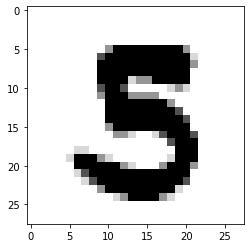

In [31]:
index = 1003
print("Following digit to be recognized:")
show_img(x_test_data_norm,index)

In [54]:
#storing separate models for each percentage(models are indexed with loop counter)

#perc=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
perc=[0.05,0.10,0.15]
coreset_accuracy=[]
label_prediction = []
coreset_model = [0]*len(perc)
coreset_sample = [0]*len(perc)
df_sample = pd.DataFrame()
print("Begin test: ")
for j in range(len(perc)):
    
    coreset_size=int(perc[j]*len(kl_load20))
    coreset_data_label=x_data_label_kl_merge_idx_sort[(20000-coreset_size):20000]
    #coreset_data_label=x_data_label_kl_merge_idx_sort[0:coreset_size]
    coreset_sample=coreset_data_label[:,[786]]
    coreset_data=coreset_data_label[:, 0:784]
    coreset_label=coreset_data_label[:,[784]]
    
    df2=pd.DataFrame(coreset_data_label[:,[786]])
    print(df2)
    df2.to_csv("file1"+str(j)+".csv") 
    df_sample.append(df2)
   
    print("Size of Coreset: " +str(len(coreset_data)))
    
    #format conversion
    #convert coreset record to 2D for DL feeding
    coreset_data_2D=[]
    for k in range(len(coreset_data)):
        #coreset_data[k] *= 255
        sqr=np.reshape(coreset_data[k],(28,28))
        coreset_data_2D.append(sqr)

    coreset_data_2D_np=np.array(coreset_data_2D)
    coreset_data_2D_np.shape
    
    #preprocessing for Keras
    coreset_data_2D_train = coreset_data_2D_np.reshape(coreset_data_2D_np.shape[0], 28, 28, 1)
    
    #model initialization
    # Creating a Sequential Model and adding the layers
    input_shape = (28, 28, 1)
    coreset_model[j] = Sequential()
    coreset_model[j].add(Conv2D(28, kernel_size=(4,4), input_shape=input_shape))
    coreset_model[j].add(MaxPooling2D(pool_size=(2, 2)))
    coreset_model[j].add(Flatten()) # Flattening the 2D arrays for fully connected layers
    coreset_model[j].add(Dense(128, activation=tf.nn.relu))
    coreset_model[j].add(Dropout(0.2))
    coreset_model[j].add(Dense(10,activation=tf.nn.softmax))
    
    #model training
    coreset_model[j].compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    coreset_model[j].fit(x=coreset_data_2D_train,y=coreset_label, epochs=10)
    
    #model evaluation
    cset_acc=coreset_model[j].evaluate(x_data_2D_test,x_test_label)[1]
    print("\nAccuracy="+str(cset_acc))
    coreset_accuracy.append(cset_acc)
    
    #testing with a test image
    pred = coreset_model[j].predict(x_data_2D_test[index].reshape(1, 28, 28, 1))
    label_prediction.append(pred.argmax())
    print("Test Label: "+str(x_test_label[index]))
    print("Predicted Label: "+str(pred.argmax()))
print("========================")
print("All predictions: ")    
print(label_prediction)    

Begin test: 
           0
0     3198.0
1    18804.0
2      194.0
3     4814.0
4    11379.0
..       ...
995  10984.0
996   9687.0
997  11746.0
998  10936.0
999  17602.0

[1000 rows x 1 columns]
Size of Coreset: 1000
Epoch 1/10
1000/1000 [==============================] - 0s 444us/sample - loss: 1.0697 - acc: 0.6620
Epoch 2/10
1000/1000 [==============================] - 0s 306us/sample - loss: 0.3907 - acc: 0.8760
Epoch 3/10
1000/1000 [==============================] - 0s 267us/sample - loss: 0.2526 - acc: 0.9240
Epoch 4/10
1000/1000 [==============================] - 0s 237us/sample - loss: 0.1956 - acc: 0.9440
Epoch 5/10
1000/1000 [==============================] - 0s 244us/sample - loss: 0.1143 - acc: 0.9720
Epoch 6/10
1000/1000 [==============================] - 0s 241us/sample - loss: 0.0973 - acc: 0.9750
Epoch 7/10
1000/1000 [==============================] - 0s 283us/sample - loss: 0.0724 - acc: 0.9800
Epoch 8/10
1000/1000 [==============================] - 0s 300us/sample - los

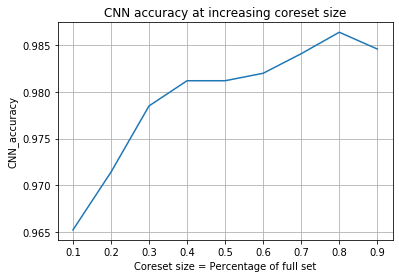

In [27]:
plt.grid(True)
plt.xlabel('Coreset size = Percentage of full set')
plt.ylabel('CNN_accuracy')
plt.title('CNN accuracy at increasing coreset size')
plt.plot(perc,coreset_accuracy)
plt.savefig("Cnn_acc4x4_2.png")

In [30]:
coreset_accuracy

[0.9652, 0.9714, 0.9785, 0.9812, 0.9812, 0.982, 0.9841, 0.9864, 0.9846]

Following digit to be recognized:


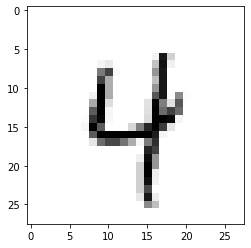

Test Sample No: 1552
Predicted Label with 0.1 ratio having accuracy 0.9652 : 4
Predicted Label with 0.2 ratio having accuracy 0.9714 : 4
Predicted Label with 0.3 ratio having accuracy 0.9785 : 4
Predicted Label with 0.4 ratio having accuracy 0.9812 : 4
Predicted Label with 0.5 ratio having accuracy 0.9812 : 4
Predicted Label with 0.6 ratio having accuracy 0.982 : 4
Predicted Label with 0.7 ratio having accuracy 0.9841 : 4
Predicted Label with 0.8 ratio having accuracy 0.9864 : 4
Predicted Label with 0.9 ratio having accuracy 0.9846 : 4
Test Label: [4]
All predictions: 
[4, 4, 4, 4, 4, 4, 4, 4, 4]
Following digit to be recognized:


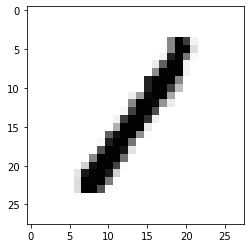

Test Sample No: 7563
Predicted Label with 0.1 ratio having accuracy 0.9652 : 1
Predicted Label with 0.2 ratio having accuracy 0.9714 : 1
Predicted Label with 0.3 ratio having accuracy 0.9785 : 1
Predicted Label with 0.4 ratio having accuracy 0.9812 : 1
Predicted Label with 0.5 ratio having accuracy 0.9812 : 1
Predicted Label with 0.6 ratio having accuracy 0.982 : 1
Predicted Label with 0.7 ratio having accuracy 0.9841 : 1
Predicted Label with 0.8 ratio having accuracy 0.9864 : 1
Predicted Label with 0.9 ratio having accuracy 0.9846 : 1
Test Label: [1]
All predictions: 
[1, 1, 1, 1, 1, 1, 1, 1, 1]
Following digit to be recognized:


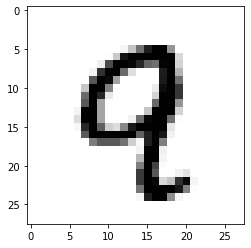

Test Sample No: 1282
Predicted Label with 0.1 ratio having accuracy 0.9652 : 9
Predicted Label with 0.2 ratio having accuracy 0.9714 : 9
Predicted Label with 0.3 ratio having accuracy 0.9785 : 9
Predicted Label with 0.4 ratio having accuracy 0.9812 : 9
Predicted Label with 0.5 ratio having accuracy 0.9812 : 9
Predicted Label with 0.6 ratio having accuracy 0.982 : 9
Predicted Label with 0.7 ratio having accuracy 0.9841 : 9
Predicted Label with 0.8 ratio having accuracy 0.9864 : 9
Predicted Label with 0.9 ratio having accuracy 0.9846 : 9
Test Label: [9]
All predictions: 
[9, 9, 9, 9, 9, 9, 9, 9, 9]
Following digit to be recognized:


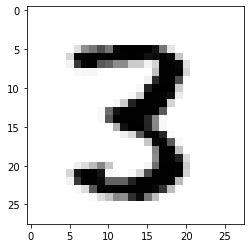

Test Sample No: 1804
Predicted Label with 0.1 ratio having accuracy 0.9652 : 3
Predicted Label with 0.2 ratio having accuracy 0.9714 : 3
Predicted Label with 0.3 ratio having accuracy 0.9785 : 3
Predicted Label with 0.4 ratio having accuracy 0.9812 : 3
Predicted Label with 0.5 ratio having accuracy 0.9812 : 3
Predicted Label with 0.6 ratio having accuracy 0.982 : 3
Predicted Label with 0.7 ratio having accuracy 0.9841 : 3
Predicted Label with 0.8 ratio having accuracy 0.9864 : 3
Predicted Label with 0.9 ratio having accuracy 0.9846 : 3
Test Label: [3]
All predictions: 
[3, 3, 3, 3, 3, 3, 3, 3, 3]
Following digit to be recognized:


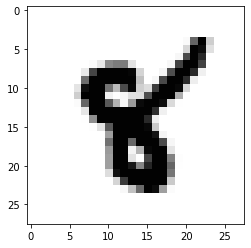

Test Sample No: 5644
Predicted Label with 0.1 ratio having accuracy 0.9652 : 8
Predicted Label with 0.2 ratio having accuracy 0.9714 : 8
Predicted Label with 0.3 ratio having accuracy 0.9785 : 8
Predicted Label with 0.4 ratio having accuracy 0.9812 : 8
Predicted Label with 0.5 ratio having accuracy 0.9812 : 8
Predicted Label with 0.6 ratio having accuracy 0.982 : 8
Predicted Label with 0.7 ratio having accuracy 0.9841 : 8
Predicted Label with 0.8 ratio having accuracy 0.9864 : 8
Predicted Label with 0.9 ratio having accuracy 0.9846 : 8
Test Label: [8]
All predictions: 
[8, 8, 8, 8, 8, 8, 8, 8, 8]
Following digit to be recognized:


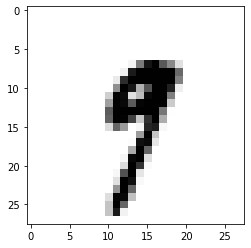

Test Sample No: 7044
Predicted Label with 0.1 ratio having accuracy 0.9652 : 9
Predicted Label with 0.2 ratio having accuracy 0.9714 : 9
Predicted Label with 0.3 ratio having accuracy 0.9785 : 9
Predicted Label with 0.4 ratio having accuracy 0.9812 : 9
Predicted Label with 0.5 ratio having accuracy 0.9812 : 9
Predicted Label with 0.6 ratio having accuracy 0.982 : 9
Predicted Label with 0.7 ratio having accuracy 0.9841 : 9
Predicted Label with 0.8 ratio having accuracy 0.9864 : 9
Predicted Label with 0.9 ratio having accuracy 0.9846 : 9
Test Label: [9]
All predictions: 
[9, 9, 9, 9, 9, 9, 9, 9, 9]
Following digit to be recognized:


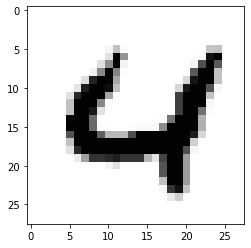

Test Sample No: 2319
Predicted Label with 0.1 ratio having accuracy 0.9652 : 4
Predicted Label with 0.2 ratio having accuracy 0.9714 : 4
Predicted Label with 0.3 ratio having accuracy 0.9785 : 4
Predicted Label with 0.4 ratio having accuracy 0.9812 : 4
Predicted Label with 0.5 ratio having accuracy 0.9812 : 4
Predicted Label with 0.6 ratio having accuracy 0.982 : 4
Predicted Label with 0.7 ratio having accuracy 0.9841 : 4
Predicted Label with 0.8 ratio having accuracy 0.9864 : 4
Predicted Label with 0.9 ratio having accuracy 0.9846 : 4
Test Label: [4]
All predictions: 
[4, 4, 4, 4, 4, 4, 4, 4, 4]
Following digit to be recognized:


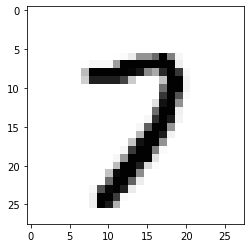

Test Sample No: 7460
Predicted Label with 0.1 ratio having accuracy 0.9652 : 7
Predicted Label with 0.2 ratio having accuracy 0.9714 : 7
Predicted Label with 0.3 ratio having accuracy 0.9785 : 7
Predicted Label with 0.4 ratio having accuracy 0.9812 : 7
Predicted Label with 0.5 ratio having accuracy 0.9812 : 7
Predicted Label with 0.6 ratio having accuracy 0.982 : 7
Predicted Label with 0.7 ratio having accuracy 0.9841 : 7
Predicted Label with 0.8 ratio having accuracy 0.9864 : 7
Predicted Label with 0.9 ratio having accuracy 0.9846 : 7
Test Label: [7]
All predictions: 
[7, 7, 7, 7, 7, 7, 7, 7, 7]
Following digit to be recognized:


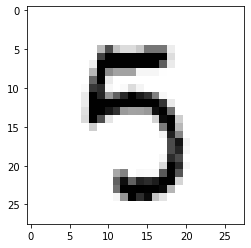

Test Sample No: 3312
Predicted Label with 0.1 ratio having accuracy 0.9652 : 5
Predicted Label with 0.2 ratio having accuracy 0.9714 : 5
Predicted Label with 0.3 ratio having accuracy 0.9785 : 5
Predicted Label with 0.4 ratio having accuracy 0.9812 : 5
Predicted Label with 0.5 ratio having accuracy 0.9812 : 5
Predicted Label with 0.6 ratio having accuracy 0.982 : 5
Predicted Label with 0.7 ratio having accuracy 0.9841 : 5
Predicted Label with 0.8 ratio having accuracy 0.9864 : 5
Predicted Label with 0.9 ratio having accuracy 0.9846 : 5
Test Label: [5]
All predictions: 
[5, 5, 5, 5, 5, 5, 5, 5, 5]
Following digit to be recognized:


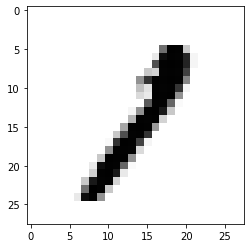

Test Sample No: 9653
Predicted Label with 0.1 ratio having accuracy 0.9652 : 1
Predicted Label with 0.2 ratio having accuracy 0.9714 : 1
Predicted Label with 0.3 ratio having accuracy 0.9785 : 1
Predicted Label with 0.4 ratio having accuracy 0.9812 : 1
Predicted Label with 0.5 ratio having accuracy 0.9812 : 1
Predicted Label with 0.6 ratio having accuracy 0.982 : 1
Predicted Label with 0.7 ratio having accuracy 0.9841 : 1
Predicted Label with 0.8 ratio having accuracy 0.9864 : 1
Predicted Label with 0.9 ratio having accuracy 0.9846 : 1
Test Label: [1]
All predictions: 
[1, 1, 1, 1, 1, 1, 1, 1, 1]


In [29]:
#testing over few images
import random


for i in range(0,10):
    index=random.randint(0,10000)
    print("Following digit to be recognized:")
    show_img(x_test_data_norm,index)
    plt.show()
    print("Test Sample No: "+str(index))
    pred_label = []
    coreset_acc = []
    
    for j in range(len(perc)):
        
        #model evaluation
        #cset_accuracy=coreset_model[j].evaluate(x_data_2D_test,x_test_label)[1]
        #print("\nAccuracy="+str(cset_accuracy))
        #coreset_acc.append(cset_accuracy)
        
        pred = coreset_model[j].predict(x_data_2D_test[index].reshape(1, 28, 28, 1))
        pred_label.append(pred.argmax())
        print("Predicted Label with "+str(perc[j])+" ratio having accuracy "+str(coreset_accuracy[j])+" : "+str(pred.argmax()))
    print("========================")
    print("Test Label: "+str(x_test_label[index]))
    print("All predictions: ")    
    print(pred_label)    
    
        

